In [1]:
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
def get_metrics(y_true, y_hat):
    acc = sklearn.metrics.accuracy_score(y_true, y_hat)
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_true, y_hat)
    return acc, balanced_acc

In [3]:
train_data = np.genfromtxt("datasets/Syndata-train.csv", delimiter=",")[1:]
X_train = train_data[:, :2]
y_train = train_data[:, 2:]

test_data = np.genfromtxt("datasets/Syndata-test.csv", delimiter=",")[1:]
X_test = test_data[:, :2]
y_test = test_data[:, 2:]

In [4]:
class DecisionStump:
    def __init__(self, granularity=10):
        self.best_feature = None
        self.best_direction = None
        self.best_position = None
        self.granularity = granularity

    def train(self, X, y, dist_t):
        """
        arguments:
        X: n✕d training inputs
        y: n✕1 labels with values 1 or -1
        dist_t: n✕1 distribution of samples
        ------------------------------------------
        output:
        e_t: 0/1 loss of h_t which has to be less than 0.5
        """

        X = np.asarray(X)
        y = np.asarray(y)
        dist_t = np.asarray(dist_t)

        # maximum value for error is 1
        e_t = 1
        for feature in range(X.shape[1]):
            err, direction, position = self.__find_best_separator(
                X[:, feature], y, dist_t
            )
            if err < e_t:
                e_t = err
                self.best_feature = feature
                self.best_direction = direction
                self.best_position = position

        return e_t

    # for a given feature, finds the best separator
    def __find_best_separator(self, x, y, dist_t):
        """
        x: n✕1 one feature of inputs
        y: n✕1 labels with values 1 or -1
        dist_t: n✕1 distribution of samples
        ------------------------------------------
        output:
        e_t: 0/1 loss of h_t which has to be less than 0.5
        best_dir: defines which side of the separator gets +1 label
        best_pos: defines the value of the feature used to separate the data
        """

        best_dir = 1
        best_pos = x.min()

        # maximum value for error is 1
        e_t = 1
        for p in np.arange(x.min(), x.max(), (x.max() - x.min()) / self.granularity):
            for d in (-1, 1):
                y_hat = np.ones((y.size)).reshape(-1, 1)
                if d == 1:
                    y_hat[x < p] = -1
                else:
                    y_hat[x > p] = -1

                err = np.sum((y_hat != y) * dist_t)
                if err < e_t:
                    e_t = err
                    best_dir = d
                    best_pos = p

        return e_t, best_dir, best_pos

    def predict(self, X_test):
        """
        X_test: n✕d test inputs
        ------------------------------------------
        output:
        y_hat: n✕1 predicted labels with values 1 or -1
        """

        X_test = np.asarray(X_test)
        if X_test.ndim == 1:
            X_test = X_test[np.newaxis, :]

        y_hat = np.ones((X_test.shape[0]))
        if self.best_direction == 1:
            y_hat[X_test[:, self.best_feature] < self.best_position] = -1
        else:
            y_hat[X_test[:, self.best_feature] > self.best_position] = -1

        return y_hat

In [5]:
class AdaBoost:
    def __init__(self, num_iter):
        self.T = num_iter
        self.h = [None for _ in range(self.T)]
        self.alpha = [None for _ in range(self.T)]
        # weak learner loss
        self.e = [None for _ in range(self.T)]

    # this method can get much faster using vectorization
    def __get_new_dist(self, wl, X, y, alpha_t, old_dist):
        new_dist = []
        denominator = 0
        for j in range(X.shape[0]):
            denominator += old_dist[j] * np.exp(-alpha_t * y[j] * wl.predict(X[j]))

        for i in range(X.shape[0]):
            numerator = old_dist[i] * np.exp(-alpha_t * y[i] * wl.predict(X[i]))
            new_dist.append(numerator / denominator)

        return np.asarray(new_dist).reshape(-1, 1)

    
    def train(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # sample distribution is initialized by 1/N
        sample_dist = np.ones((X.shape[0])).reshape(-1, 1) / X.shape[0]
        for t in range(self.T):
            wl = DecisionStump()
            self.h[t] = wl
            self.e[t] = wl.train(X, y, sample_dist)
            self.alpha[t] = (1 / 2) * np.log((1 / self.e[t]) - 1)
            sample_dist = self.__get_new_dist(wl, X, y, self.alpha[t], sample_dist)
            
    
    # user can set T to the number of weak learners used for prediction 
    def predict(self, X, T):
        assert T <= len([i for i in self.h if i is not None])
        X = np.asarray(X)
        y_hat = 0
        for t in range(T):
            y_hat += self.alpha[t] * self.h[t].predict(X)

        return np.sign(y_hat)

Here we train the model with T=4000. We can then use it for any $\ t \leq T \ $ because the parameters are all saved within the model

In [6]:
T = 4000
adaboost = AdaBoost(num_iter=T)
adaboost.train(X_train, y_train)

# How $\epsilon_t$ (zero/one loss of $h_t$) Changes
In general $\epsilon_t$ gets higher as $t$ increases. This is due to the fact that the model is changing the distribution of sample weights so that it will focus on its previous mistakes.
This is a challenge for the weak learner beacause it has to classify harder and harder distributions.

The following plots show this trend for $t=20$ and $t=100$. We can see that it's approaching 0.5 but still stays below this threshold and serves better than chance.

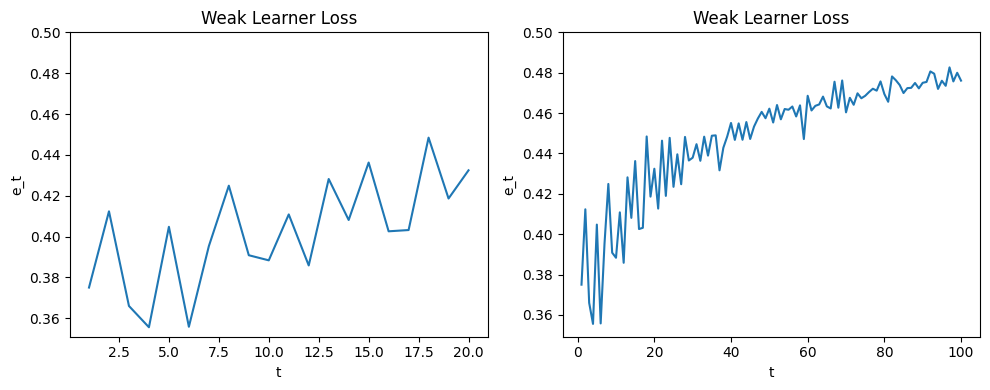

The highest weak learner error with T=20 is 0.4484203440861432 which was at t=17


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(range(1, 20 + 1), adaboost.e[:20])
axes[0].set_title("Weak Learner Loss")
axes[0].set_xlabel("t")
axes[0].set_ylabel("e_t")
axes[0].set_ylim(None, 0.5)

axes[1].plot(range(1, 100 + 1), adaboost.e[:100])
axes[1].set_title("Weak Learner Loss")
axes[1].set_xlabel("t")
axes[1].set_ylabel("e_t")
axes[1].set_ylim(None, 0.5)

plt.tight_layout()
plt.show()

worst_t, worst_e = max(enumerate(adaboost.e[:20]), key=lambda x: x[1])
print(f"The highest weak learner error with T=20 is {worst_e} which was at t={worst_t}")

# How $E_t$ (zero/one loss of $sign(H_t$)) Changes
$E_t = \frac{1}{N} \sum_{i=1}^{N} 1_{sign(H_t(x^{(i)})) \neq y^{(i)}}$

As we can see, both the training and the testing errors are getting lower as the time steps increase. This is because the data is more complicated than what a single weak learner can classify hence it gets better by utilizing more weak learners.
Another fact is that the test data seems to be quite the same as the training data because their losses are so close.

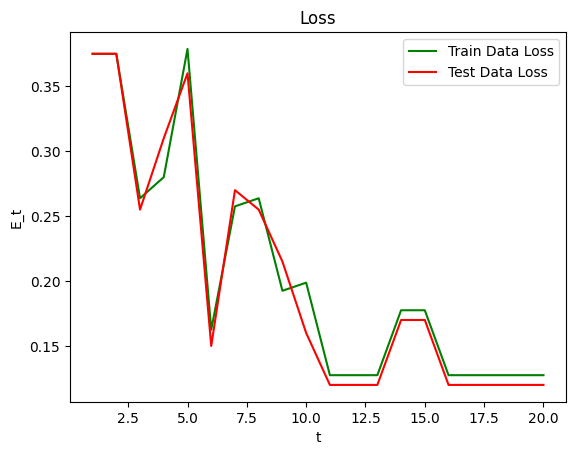

In [8]:
E_train, E_test = [], []
time_steps = range(1, 20 + 1)
for t in time_steps:
    y_train_hat = adaboost.predict(X_train, t).reshape(-1,1)
    E_train.append(np.sum(y_train != y_train_hat) / y_train.shape[0])

    y_test_hat = adaboost.predict(X_test, t).reshape(-1,1)
    E_test.append(np.sum(y_test != y_test_hat) / y_test.shape[0])

plt.plot(time_steps, E_train, label='Train Data Loss', color='green')
plt.plot(time_steps, E_test, label='Test Data Loss', color='red')
plt.title("Loss")
plt.xlabel("t")
plt.ylabel("E_t")
plt.legend()
plt.show()


# How $E_t$ Changes With Bigger $t$
First noticable thing is that the test error is still getting better while the training error is plateaued. This is because despite the bias of the model getting stuck, the varicance is still getting lower due to adding more ensembles.

$E_{out} = bias + variance$

So in these ensemble learning models, we should keep training the model for a while after the training error is minimized so that we get the lowest testing error possible.

The fact that the testing error is lower than the training error is due to the datasets. As we mentioned before the test data is very similar to training data and maybe even easier to predict.

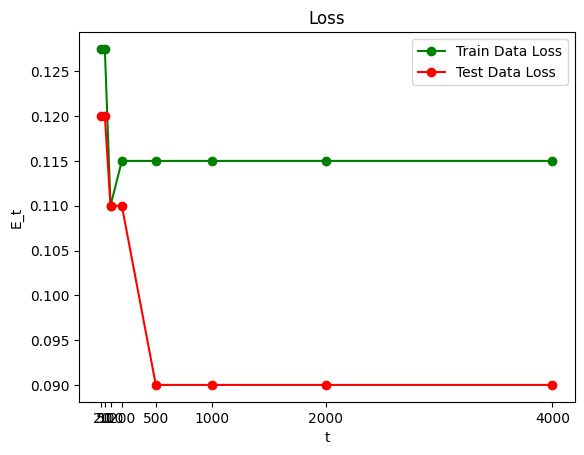

In [9]:
E_train, E_test = [], []
time_steps = (20, 50, 100, 200, 500, 1000, 2000, 4000)
for t in time_steps:
    y_train_hat = adaboost.predict(X_train, t).reshape(-1, 1)
    E_train.append(np.sum(y_train != y_train_hat) / y_train.shape[0])

    y_test_hat = adaboost.predict(X_test, t).reshape(-1, 1)
    E_test.append(np.sum(y_test != y_test_hat) / y_test.shape[0])

plt.plot(time_steps, E_train, label="Train Data Loss", color="green", marker="o")
plt.plot(time_steps, E_test, label="Test Data Loss", color="red", marker="o")
plt.title("Loss")
plt.xlabel("t")
plt.ylabel("E_t")
plt.legend()
plt.xticks(time_steps)
plt.show()